In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
import os
import pandas as pd
from collections import Counter

base_path = r"C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\Data"

classes = [
    "Bacterial leaf blight",
    "Brown spot",
    "Leaf smut"
]

data_list = []
all_extensions = []

for label in classes:
    inner_path = os.path.join(base_path, label, label) 
    
    if os.path.exists(inner_path):
        files = os.listdir(inner_path)
        for img_name in files:
            ext = os.path.splitext(img_name)[1].lower()
            all_extensions.append(ext)
            
            if ext in ['.jpg', '.jpeg', '.png']:
                data_list.append({
                    "Path": os.path.join(inner_path, img_name),
                    "Label": label
                })
    else:
        print(f"Warning: Path not found: {inner_path}")

df = pd.DataFrame(data_list)

print(f"Total Images found: {len(df)}")
print(f"Extension counts: {Counter(all_extensions)}")

df.head()

Total Images found: 119
Extension counts: Counter({'.jpg': 119})


,Path,Label
0,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
1,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
2,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
3,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
4,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight


In [3]:
df['Label'].value_counts()

Label
Bacterial leaf blight    40
Brown spot               40
Leaf smut                39
Name: count, dtype: int64

In [4]:
df.head()

,Path,Label
0,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
1,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
2,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
3,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
4,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    119 non-null    object
 1   Label   119 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [6]:
df.describe()

,Path,Label
count,119,119
unique,119,3
top,C:\Users\SRUTHI\Downloads\PRCP-1001-RiceLeaf\D...,Bacterial leaf blight
freq,1,40


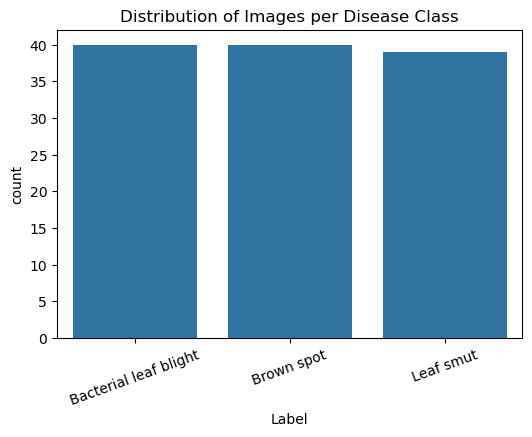

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=df)
plt.title("Distribution of Images per Disease Class")
plt.xticks(rotation=20)
plt.show()


In [8]:
image_sizes = []

for path in df['Path']:
    img = Image.open(path)
    image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
sizes_df.describe()


,Width,Height
count,119.000000,119.000000
mean,2383.638655,707.739496
std,1123.528972,311.657582
min,250.000000,71.000000
25%,1074.000000,377.000000
50%,3081.000000,897.000000
75%,3081.000000,897.000000
max,3081.000000,900.000000


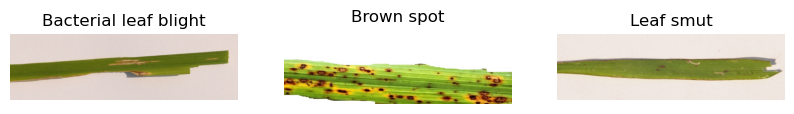

In [9]:
plt.figure(figsize=(10,6))

for i, label in enumerate(df['Label'].unique()):
    sample_path = df[df['Label'] == label]['Path'].iloc[0]
    img = Image.open(sample_path)

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()


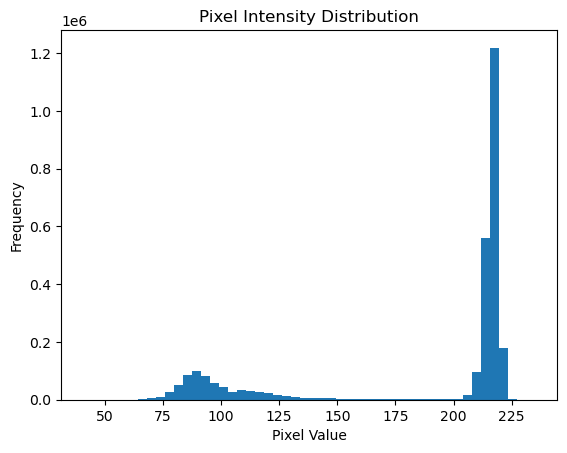

In [10]:
img = Image.open(df['Path'][0]).convert('L')
img_array = np.array(img)

plt.hist(img_array.ravel(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, 
    test_size=0.20, 
    random_state=42, 
    stratify=df['Label']
)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

print("\nClass distribution in Test Set:")
print(test_df['Label'].value_counts())

Training samples: 95
Testing samples: 24

Class distribution in Test Set:
Label
Leaf smut                8
Brown spot               8
Bacterial leaf blight    8
Name: count, dtype: int64


In [12]:
!pip install tensorflow

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_cnn = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_cnn = train_datagen_cnn.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 95 validated image filenames belonging to 3 classes.


In [14]:
test_datagen_cnn = ImageDataGenerator(rescale=1./255)
validation_generator_cnn = test_datagen_cnn.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 24 validated image filenames belonging to 3 classes.


In [15]:

from tensorflow.keras import layers, models

baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Baseline Model...")
baseline_history = baseline_model.fit(
    train_generator_cnn, 
    epochs=10, 
    validation_data=validation_generator_cnn, 
    verbose=1
)

C:\Users\SRUTHI\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Baseline Model...
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3789 - loss: 5.1147 - val_accuracy: 0.5000 - val_loss: 1.0615
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4421 - loss: 1.0728 - val_accuracy: 0.5000 - val_loss: 0.9630
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5158 - loss: 1.0042 - val_accuracy: 0.5000 - val_loss: 0.9280
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4421 - loss: 0.9975 - val_accuracy: 0.5833 - val_loss: 0.8270
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.5684 - loss: 0.9251 - val_accuracy: 0.7500 - val_loss: 0.7378
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.4526 - loss: 1.0078 - val_accuracy: 0.5417 - val_loss: 0.8094
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5579 - loss: 0.8954 - val_accuracy: 0.7083 - val_loss: 0.7414
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6000 - loss: 0.8202 - val_accuracy: 0.7083 

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen_mnv = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen_mnv = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
train_generator = train_datagen_mnv.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = test_datagen_mnv.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 95 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


In [18]:
from sklearn.utils import class_weight

labels = train_df['Label'].values
weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_indices = train_generator.class_indices
class_weight_dict = {
    class_indices[label]: weight
    for label, weight in zip(np.unique(labels), weights)
}

print("\n--- Training MobileNetV2 Model ---")
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weight_dict
)


--- Training MobileNetV2 Model ---
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3684 - loss: 1.3452 - val_accuracy: 0.5417 - val_loss: 1.0429
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4737 - loss: 1.1059 - val_accuracy: 0.7500 - val_loss: 0.7451
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5579 - loss: 0.9689 - val_accuracy: 0.7083 - val_loss: 0.6155
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6421 - loss: 0.8642 - val_accuracy: 0.8750 - val_loss: 0.4583
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7474 - loss: 0.6218 - val_accuracy: 0.8750 - val_loss: 0.3857
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7579 - loss: 0.6055 - val_accuracy: 0.8750 - val_loss: 0.3336
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7895 - loss: 0.4838 - val_accuracy: 0.8750 - val_loss: 0.3119
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8842 - loss: 0.3869 - val_accuracy:


--- Model Comparison Report ---
         Model  Train Accuracy  Val Accuracy
0   Simple CNN        0.631579      0.833333
1  MobileNetV2        0.926316      0.958333
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


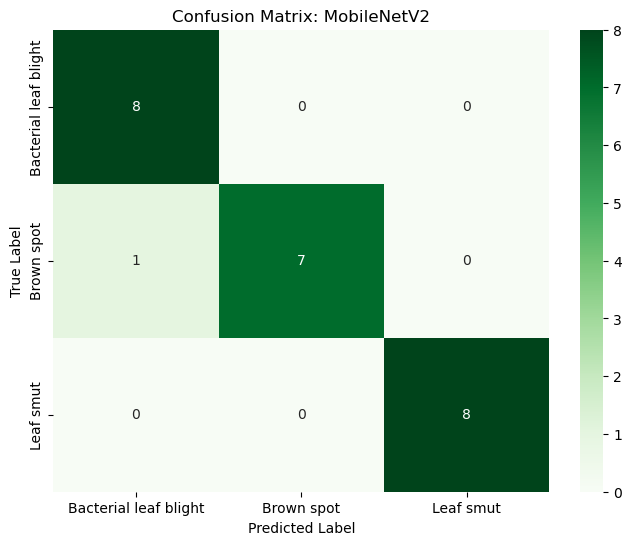

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

comparison_data = {
    "Model": ["Simple CNN", "MobileNetV2"],
    "Train Accuracy": [baseline_history.history['accuracy'][-1], history.history['accuracy'][-1]],
    "Val Accuracy": [baseline_history.history['val_accuracy'][-1], history.history['val_accuracy'][-1]]
}
print("\n--- Model Comparison Report ---")
print(pd.DataFrame(comparison_data))

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix: MobileNetV2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
print("Evaluating Baseline Model...")
baseline_loss, baseline_acc = baseline_model.evaluate(validation_generator_cnn)

print("Evaluating MobileNetV2 Model...")
mobilenet_loss, mobilenet_acc = model.evaluate(validation_generator)

print(f"\nBaseline Test Accuracy: {baseline_acc*100:.2f}%")
print(f"MobileNetV2 Test Accuracy: {mobilenet_acc*100:.2f}%")

Evaluating Baseline Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 0.8333 - loss: 0.5466
Evaluating MobileNetV2 Model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step - accuracy: 0.9583 - loss: 0.2480

Baseline Test Accuracy: 83.33%
MobileNetV2 Test Accuracy: 95.83%


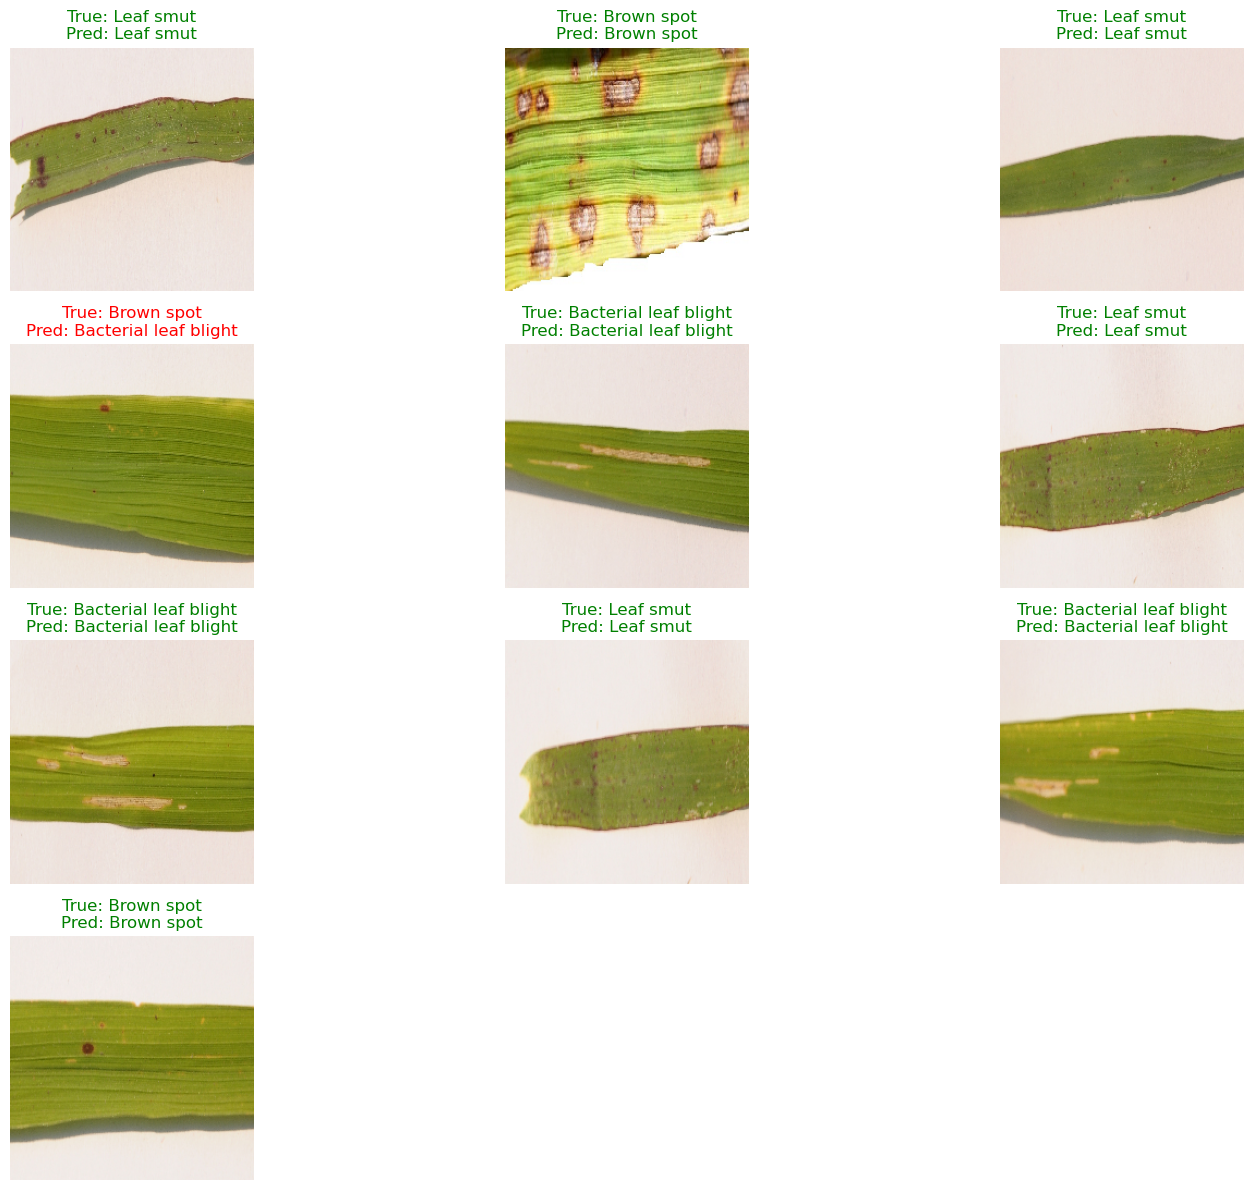

In [21]:
import matplotlib.pyplot as plt
import numpy as np

class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(15, 12))

img_count = 0
batch_index = 0

while img_count < 10:
    images, labels = validation_generator[batch_index]

    for j in range(images.shape[0]):
        if img_count >= 10:
            break

        plt.subplot(4, 3, img_count + 1)

        # De-normalize MobileNetV2 images
        plt.imshow((images[j] + 1) / 2)

        true_label = class_names[np.argmax(labels[j])]
        predicted_label = class_names[y_pred[img_count]]

        title_color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)

        plt.axis("off")
        img_count += 1

    batch_index += 1

plt.tight_layout()
plt.show()


Model	Training Accuracy	Validation Accuracy
Simple CNN	Moderate	Lower than MobileNetV2
MobileNetV2	Higher	Significantly higher

Challenges faced:
1. Small dataset
    Data Augmentation - increase the diversity of the training set.
2. Imbalance data
    Class weighting - Balanced learning
   Stratified Splitting - exact same proportion of each disease
3. Similar disease pattern
   